# Introduction
When most people think about "AI" or LLMs (like ChatGPT) they picture them as chatbots
generating free-form text and stop there.


---

Most people meet a large-language model in a chat box. They ask a question, watch sentences spill out, and judge the system—often with a shrug—as a well-trained autocomplete. That first impression is fair but shallow. An LLM is, in fact, a machine that writes by rolling a weighted die for every word. Because each toss is a little random, the model can answer the same prompt twice and land on two different stories. Sometimes the change is harmless: a shift in tone or word choice. Sometimes it is serious: an invented statistic, a misplaced date, or a confident claim that never happened.

That uncertainty is tolerable when you are brainstorming headlines or riffing on recipe ideas. It becomes dangerous the moment the text must feed another tool. Imagine copying an LLM’s reply into a spreadsheet that expects “Price” in column C and “Currency” in column D. If one extra sentence slips in, the cells shift, formulas break, and the error hides until the quarterly report is wrong by millions.

Picture the difference between handing someone a blank sheet of paper and handing them a tax form. On the blank page they can doodle, write a poem, or ramble for paragraphs—and you’ll have to sift through the mess to find the one number you actually need. A tax form, by contrast, boxes every figure into a labeled slot: “Income,” “Deductions,” “Total Owing.” No guesswork, no clutter—just data in the right place. Structured output works the same way for an LLM: you give the model a form to fill out (“exactly these fields, in this order, nothing extra”), and any answer that breaks the template is instantly rejected. The model still does the thinking, but the structure ensures its thoughts arrive in a format you can sort, sum, or feed straight into a spreadsheet without touching a single regex.

Structured output gives an LLM a tax-form of its own. Instead of hoping the model answers in the right shape, you hand it a template— “Give me exactly these fields, in this order, and nothing else.” If the reply deviates, you know immediately. The technique doesn’t cure deeper issues such as bias or hallucination, but it does guarantee that whatever the model says arrives in a format you can sort, sum, or load into any tool that expects tidy data.


Structure does not fix every weakness. The model can still fabricate a fact or echo a bias. What structure does offer is a solid surface for the next step in the pipeline. With the format guaranteed—often as simple as a small piece of JSON—engineers, analysts, and auditors can focus on verifying truth, checking fairness, and protecting privacy rather than untangling text. In short, the blank page becomes a form, and the chatbot becomes a dependable part of the toolchain.



## From Chat Window to Probability Distribution

Every time an LLM answers a prompt it marches forward one token at a time, sampling from a probability distribution estimated by its neural network. Parameters such as `temperature`, `top-k`, and `top-p` decide how sharp or wide that distribution is; higher values increase creativity but also variance.

Because the sampling step is inherently random, two identical prompts can yield subtly different facts, styles, or even conclusions.


---



LLMs can generate text that can veer off-topic or contain fabricated details. This unpredictability poses a serious challenge for organizations that need to distill consistent, structured data (e.g., addresses, invoices, summaries) from large volumes of unstructured text. 


This often makes LLMs too unpredictable and unreliable for real-world tasks, especially in enterprise or mission-critical settings. These criticisms are completely valid since LLMs are probabilistic, generative systems prone to variability. Traditional unstructured text output is hard to trust if the LLM “hallucinates” or drift off-topic.
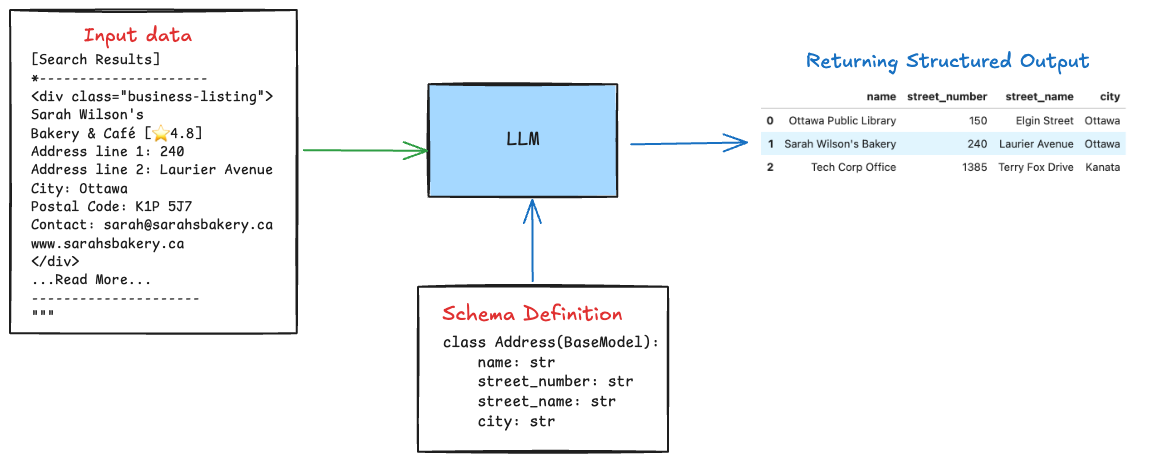

**Structured extraction** is an approach that helps partially mitigate these concerns.

Instead of requesting open-ended text, we give the model a **blueprint** (a strictly defined schema and demand the output adhere to it). We specify *exactly how we want the model’s output to look*—in this case, structured data in JSON. Then, we use **Pydantic** (a Python library) to formally define and validate that output by enforcing type definitions and validates JSON data

This constrained use of AI addresses one of the biggest concerns: **unpredictability**. By requiring the model to produce output that follows a strict schema, any errors become more detectable, and the output can be systematically processed. Structured extraction places a guardrail around the model:


1. Define a schema describing exactly what fields and data types are expected.
2. Instruct the LLM to return JSON conforming to that schema.
2. If the LLM returns something that doesn’t match the schema, we can immediately detect the error and handle it (e.g., ask the model again, or flag the output).



This approach reduces the “black-box” feeling of AI text generation, making outputs more transparent, testable, and suitable for downstream workflows. By constraining the model’s responses to a known structure, we transform what might otherwise be a black-box AI process into a predictable and testable system—precisely the kind of safeguard critics demand.

Below, we illustrate how to implement structured extraction in practice, using code samples to demonstrate each step of guiding an LLM to produce verifiable JSON responses.

## How Structured Extraction Works 

Before demonstrating how to guide a Large Language Model (LLM) toward a strict schema, it’s instructive to see what happens without any constraints. In the following example, we simply prompt the model about Canada, only limiting the number of tokens (for brevity) rather than specifying any structured output.

Here we're just using the Ollama library and using the LLaMA 3.18b model, running it locally on our machine. 

In [19]:
from ollama import chat
from pprint import pprint as pp

response = chat(
  messages=[
    {
      'role': 'user',
      'content': 'Tell me about Canada.',
    }
  ],
  model='llama3.1',
  options={'num_predict': 150} # Maximum number of tokens to predict when generating text
)
pp(response.message.content)

('Canada! The Great White North is a vast and beautiful country located in '
 "North America, sharing the world's longest international border with the "
 'United States to the south. Here are some interesting facts about Canada:\n'
 '\n'
 '**Geography**\n'
 '\n'
 'Canada is a large country, covering an area of approximately 10 million '
 'square kilometers (3.9 million sq mi). It has a diverse geography, featuring '
 'mountains (including the Canadian Rockies), forests, lakes, rivers, and '
 'coastlines along the Atlantic, Pacific, and Arctic Oceans. The country can '
 'be divided into several regions: Western Canada, including British Columbia '
 'and Alberta; Central Canada, comprising provinces like Ontario and Quebec; '
 'and Eastern Canada, which includes provinces like Nova Scotia and New '
 'Brunswick.\n'
 '\n'
 '**Cities**\n'
 '\n'
 'Some of Canada')


As expected, the output is an unstructured descriptive paragraph.


### From Free-Form to Structured

Now we build on existing code examples to illustrate how an LLM can be guided to output structured ouput according to a schema. To replace this open-ended style with a structured extraction approach, we’ll use Pydantic to define a schema (i.e., which fields we expect and in what format) and then instruct the LLM to output only valid JSON matching that schema.
#### Defining a Pydantic Model

In [1]:
from pydantic import BaseModel

class Country(BaseModel):
  name: str
  capital: str
  languages: list[str]

Pydantic will automatically generate a JSON Schema to describe the fields. This schema will look like:

In [3]:
Country.model_json_schema()

{'properties': {'name': {'title': 'Name', 'type': 'string'},
  'capital': {'title': 'Capital', 'type': 'string'},
  'languages': {'items': {'type': 'string'},
   'title': 'Languages',
   'type': 'array'}},
 'required': ['name', 'capital', 'languages'],
 'title': 'Country',
 'type': 'object'}

###  Sending the Schema to the LLM

When we call the LLM, we include this JSON schema in the request so that the model knows **what** to return and **how** to format it. For instance:

In [4]:
from ollama import chat

response = chat(
  messages=[
    {
      'role': 'user',
      'content': 'Tell me about Canada.',
    }
  ],
  model='llama3.1',
  format=Country.model_json_schema(),
)

This tells the model: “Return your answer as valid JSON that matches the schema for Country.” Instead of a free-form reply, the model is instructed to produce something like:

In [5]:
response.message.content

'{ "name" : "Canada", "capital" : "Ottawa", "languages" : ["English", "French"] }'

In [6]:
class Country(BaseModel):
  name: str
  capital: str
  languages: list[str]

# 2. Ask about Canada
canada_response = chat(
  messages=[{"role": "user", "content": "Tell me about Canada."}],
  model="llama3.1",
  format=Country.model_json_schema(),
  options={'temperature': 0},
)
canada_data = json.loads(canada_response.message.content)
canada_obj = Country(**canada_data)

# 3. Ask about Mexico
mexico_response = chat(
  messages=[{"role": "user", "content": "Tell me about Mexico."}],
  model="llama3.1",
  format=Country.model_json_schema(),
  options={'temperature': 0}
)
mexico_data = json.loads(mexico_response.message.content)
mexico_obj = Country(**mexico_data)

# 4. Ask about Germany
germany_response = chat(
  messages=[{"role": "user", "content": "Tell me about Germany."}],
  model="llama3.1",
  format=Country.model_json_schema(),
    options={'temperature': 0}
)
germany_data = json.loads(germany_response.message.content)
germany_obj = Country(**germany_data)

# 5. Ask about Japan
japan_response = chat(
  messages=[{"role": "user", "content": "Tell me about Japan."}],
  model="llama3.1",
  format=Country.model_json_schema(),
    options={'temperature': 0}
)
japan_data = json.loads(japan_response.message.content)
japan_obj = Country(**japan_data)

# 6. Combine all country objects into a pandas DataFrame using model_dump()
df = pd.DataFrame([
    canada_obj.model_dump(),
    mexico_obj.model_dump(),
    germany_obj.model_dump(),
    japan_obj.model_dump()
])
df

,name,capital,languages
0,Canada,Ottawa,"[English, French]"
1,Mexico,Mexico City,"[Spanish, indigenous languages, English (widel..."
2,Germany,Berlin,"[German, English, French, Italian, Polish, Rus..."
3,Japan,Tokyo,"[Japanese, English (widely spoken)]"


### Validating the Output
Once the model responds, we validate the JSON to confirm it meets the schema:

In [6]:
country = Country.model_validate_json(response.message.content)
print(country)

name='Canada' capital='Ottawa' languages=['English', 'French']


If the output fails to match the schema (for example, the LLM omits the languages field), Pydantic raises an error. This immediate feedback loop is crucial for reliability. **We’re not simply trusting the AI to always comply; we’re enforcing compliance.**

In [7]:
from pydantic import BaseModel, conlist

class Country(BaseModel):
    name: str
    capital: str
    # Limit languages to a max of 3 items
    languages: conlist(str, max_length=3)

# 2. Ask about Canada
canada_response = chat(
  messages=[{"role": "user", "content": "Tell me about Canada."}],
  model="llama3.1",
  format=Country.model_json_schema(),
  options={'temperature': 0},
)
canada_data = json.loads(canada_response.message.content)
canada_obj = Country(**canada_data)

# 3. Ask about Mexico
mexico_response = chat(
  messages=[{"role": "user", "content": "Tell me about Mexico."}],
  model="llama3.1",
  format=Country.model_json_schema(),
  options={'temperature': 0}
)
mexico_data = json.loads(mexico_response.message.content)
mexico_obj = Country(**mexico_data)

# 4. Ask about Germany
germany_response = chat(
  messages=[{"role": "user", "content": "Tell me about Germany."}],
  model="llama3.1",
  format=Country.model_json_schema(),
    options={'temperature': 0}
)
germany_data = json.loads(germany_response.message.content)
germany_obj = Country(**germany_data)

# 5. Ask about Japan
japan_response = chat(
  messages=[{"role": "user", "content": "Tell me about Japan."}],
  model="llama3.1",
  format=Country.model_json_schema(),
    options={'temperature': 0}
)
japan_data = json.loads(japan_response.message.content)
japan_obj = Country(**japan_data)

# 6. Combine all country objects into a pandas DataFrame using model_dump()
df = pd.DataFrame([
    canada_obj.model_dump(),
    mexico_obj.model_dump(),
    germany_obj.model_dump(),
    japan_obj.model_dump()
])
df

,name,capital,languages
0,Canada,Ottawa,"[English, French]"
1,Mexico,Mexico City,"[Spanish, indigenous languages, English (widel..."
2,Germany,Berlin,"[German, English, French]"
3,Japan,Tokyo,"[Japanese, English (widely spoken)]"


In [9]:
import json
import pandas as pd
from pydantic import BaseModel
from ollama import chat

# Define our Pydantic Country schema
class Country(BaseModel):
    name: str
    capital: str
    languages: list[str]

# A short prompt template ensuring minimal commentary
prompt_template = """
You are a data extraction assistant. Provide a concise JSON object describing {country}, including:
- "name": the official name of the country
- "capital": the name of the capital city
- "languages": an array of primary spoken language(s), with no extra commentary.
"""

# List of country names we want data for
country_names = ["Canada", "Mexico", "Germany", "Japan"]

# We'll store each country's data here
results = []

for cn in country_names:
    # Fill in the country name
    prompt = prompt_template.format(country=cn)
    
    # Ask the model, telling it to adhere to the JSON schema
    response = chat(
        messages=[{"role": "user", "content": prompt}],
        model="llama3.1",
        format=Country.model_json_schema(),
        options={
            "temperature": 0,    # Minimizes variability
            "num_predict": 100   # Curb excessive rambling by limiting tokens
        }
    )
    
    # Parse JSON & validate against our Pydantic schema
    raw_json = response.message.content.strip()
    data = json.loads(raw_json)
    country_obj = Country(**data)
    
    # Convert to dict and collect
    results.append(country_obj.model_dump())

# Convert the collected data into a single DataFrame
df = pd.DataFrame(results)
df

,name,capital,languages
0,Canada,Ottawa,"[English, French]"
1,United Mexican States,Mexico City,[Spanish]
2,Germany,Berlin,[German]
3,Japan,Tokyo,[Japanese]


## Concrete Example: Addresses
Here’s a more realistic use case: parsing physical addresses from a piece of text. We define two Pydantic models, Address and Addresses:

In [7]:
from pydantic import BaseModel

class Address(BaseModel):
    name: str
    street_number: str
    street_name: str
    city: str

class Addresses(BaseModel):
    addresses: list[Address]

Let’s imagine the user has a piece of text describing several locations:

In [10]:
data =  """
The Ottawa Public Library is at 150 Elgin Street, Ottawa.
Down the street, Sarah Wilson runs her bakery at 240 Laurier Avenue, Ottawa.
Over in Kanata, Tech Corp's office is at 1385 Terry Fox Drive.
"""

We pass these messages to the LLM. The Llama 3.1 model processes the input messages and generates a response that adheres to the specified JSON schema. It uses the context from the system message to understand its role as a data parsing assistant and formats the extracted information according to the provided schema.

In [13]:
prompt = """
You are a data parsing assistant. 
User provides unstructued data containing addresses. 
Your goal is to output it as JSON.
"""
response = chat(
    model='llama3.1:8b',
    messages=[
        {"role": "system", "content": prompt},
        {"role": "user", "content": data}
    ],
    format=Addresses.model_json_schema(),  # Use Pydantic to generate the schema or format=schema
    options={'temperature': 0},  # Make responses deterministic
)

This is the raw output from the model now. 

In [14]:
pp(response.message.content)

('{\n'
 '  "addresses": [\n'
 '    {\n'
 '      "name": "Ottawa Public Library",\n'
 '      "street_number": "150",\n'
 '      "street_name": "Elgin Street",\n'
 '      "city": "Ottawa"\n'
 '    },\n'
 '    {\n'
 '      "name": "Sarah Wilson\'s Bakery",\n'
 '      "street_number": "240",\n'
 '      "street_name": "Laurier Avenue",\n'
 '      "city": "Ottawa"\n'
 '    },\n'
 '    {\n'
 '      "name": "Tech Corp Office",\n'
 '      "street_number": "1385",\n'
 '      "street_name": "Terry Fox Drive",\n'
 '      "city": "Kanata"\n'
 '    }\n'
 '  ]\n'
 '}')


After validating the JSON against our Addresses model, we can convert it into a pandas DataFrame. 

In [17]:
# Use Pydantic to validate the response
address_ouput = Addresses.model_validate_json(response.message.content)
pp(address_ouput)

Addresses(addresses=[Address(name='Ottawa Public Library', street_number='150', street_name='Elgin Street', city='Ottawa'), Address(name="Sarah Wilson's Bakery", street_number='240', street_name='Laurier Avenue', city='Ottawa'), Address(name='Tech Corp Office', street_number='1385', street_name='Terry Fox Drive', city='Kanata')])


In [18]:
import pandas as pd

def locations_to_df(addresses: Addresses) -> pd.DataFrame:
    """
    Convert locations Pydantic model to pandas DataFrame.
    Each row represents one location with all its fields.
    """
    # Convert each BusinessLocation to a dict and create DataFrame
    return pd.DataFrame([loc.model_dump() for loc in addresses.addresses])
# Assuming we have our parsed response in parsed_locations
df = locations_to_df(address_ouput)
df

,name,street_number,street_name,city
0,Ottawa Public Library,150,Elgin Street,Ottawa
1,Sarah Wilson's Bakery,240,Laurier Avenue,Ottawa
2,Tech Corp Office,1385,Terry Fox Drive,Kanata


## Conclusion

LLMs support structured outputs making it possible to constrain a model's output to a specific format defined by JSON schema. 
**Structured extraction** is a process that transforms **unstructured text** into a **structured format**, such as JSON, making it easily accessible for further processing, analysis, or storage. 

Structured outputs have many use cases includuing: 
1. Parsing data from documents
2. Extracting data from images
3. Structuring all language model responses

With the rise of LLMs, this task can now be accomplished efficiently and affordably, enabling enterprises to unlock valuable insights from large volumes of unstructured data, including PDFs, text files, and scanned documents.



In [12]:
"""
Jupyter Notebook Cell:
Demonstrates structured data extraction from messy web-scraped data
using OpenAI's 'response_format={"type": "json_object"}' + Pydantic validation.
"""

import os
import json
import pandas as pd
from typing import Optional
from pydantic import BaseModel, EmailStr, HttpUrl, ValidationError

# If you haven't installed OpenAI, do: pip install openai
from openai import OpenAI
from openai.types.chat import ChatCompletion

# -----------------------------
# 1. Define our Pydantic schema
# -----------------------------
class BusinessLocation(BaseModel):
    """
    Defines the structure of a single business record:
      - name          : The name of the organization
      - street_number : e.g., '150'
      - street_name   : e.g., 'Elgin Street'
      - city          : e.g., 'Ottawa'
      - postal_code   : Optional field (e.g., 'K1P 1L7')
      - email         : Optional field validated as an email address
      - website       : Optional field validated as a URL
    """
    name: str
    street_number: str
    street_name: str
    city: str
    postal_code: Optional[str] = None
    email: Optional[EmailStr] = None
    website: Optional[HttpUrl] = None

# -----------------------------
# 2. Prepare the prompt & data
# -----------------------------
prompt_text = """
You are a data extraction assistant.
You will be given messy, web-scraped text containing business listings.
Extract each business location as valid JSON (array of objects), with minimal commentary.
Fields needed for each location:
  - name
  - street_number
  - street_name
  - city
  - postal_code (if available)
  - email (if available)
  - website (if available)
"""

# Messy web-scraped text
data = """
[Search Results]
* Ottawa Public Library *
Contact Us > Main Branch
Located at: &nbsp;150 Elgin Street, Ottawa
Status: OPEN NOW! 📚
Customer Service: library@ottawa.ca
Visit us online: https://biblioottawalibrary.ca
Postal: K1P 1L7
---------------------
<div class="business-listing">
Sarah's Bakery & Café [⭐️4.8]
Address line 1: 240 
Address line 2: Laurier Avenue
City: Ottawa
Postal Code: K1P 5J7
Contact: sarah@sarahsbakery.ca
www.sarahsbakery.ca
</div>
...Read More...
---------------------
TECH CORP GLOBAL
www.techcorp.com/contact
📍 1385 Terry Fox Drive
Kanata, Ontario
[Click to view map]
Email: info@techcorp.com
Postal: K2K 3K2
"""

# -----------------------------
# 3. Call the OpenAI API
# -----------------------------
def call_openai_for_json(prompt: str, message: str, model_name: str = "gpt-4o") -> ChatCompletion:
    """
    Calls the OpenAI Chat Completions API with a response_format ensuring valid JSON.
    Returns a ChatCompletion object.
    """
    # Create an OpenAI client with your API key
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    completion = client.chat.completions.create(
        model=model_name,
        messages=messages,
        response_format={"type": "json_object"},  # Instructs the model to return valid JSON
    )
    return completion

response = call_openai_for_json(prompt=prompt_text, message=data)

# Raw JSON as a string
json_content = response.choices[0].message.content
print("=== RAW JSON OUTPUT ===")
print(json_content)

# -----------------------------
# 4. Parse & Validate
# -----------------------------
try:
    parsed_output = json.loads(json_content)

    # If the model only returns a single record, wrap it in a list for consistency
    if isinstance(parsed_output, dict):
        parsed_output = [parsed_output]

    # Validate each record against BusinessLocation
    validated_locations = []
    for item in parsed_output:
        validated = BusinessLocation(**item)
        validated_locations.append(validated)

    # -----------------------------
    # 5. Create a DataFrame
    # -----------------------------
    if validated_locations:
        df = pd.DataFrame([loc.model_dump() for loc in validated_locations])
        print("\n=== DATAFRAME OUTPUT ===")
        display(df)  # display() for Jupyter; or just use print(df)
    else:
        print("No valid business records found. The model returned an empty list or invalid data.")

except ValidationError as e:
    print("❌ Validation Error: The model's JSON didn't match the schema.")
    print(e)
except json.JSONDecodeError:
    print("❌ JSON parsing error: The model output wasn't valid JSON.")
except Exception as ex:
    print(f"❌ An unexpected error occurred: {ex}")

=== RAW JSON OUTPUT ===

{
  "businesses": [
    {
      "name": "Ottawa Public Library",
      "street_number": "150",
      "street_name": "Elgin Street",
      "city": "Ottawa",
      "postal_code": "K1P 1L7",
      "email": "library@ottawa.ca",
      "website": "https://biblioottawalibrary.ca"
    },
    {
      "name": "Sarah's Bakery & Café",
      "street_number": "240",
      "street_name": "Laurier Avenue",
      "city": "Ottawa",
      "postal_code": "K1P 5J7",
      "email": "sarah@sarahsbakery.ca",
      "website": "www.sarahsbakery.ca"
    },
    {
      "name": "TECH CORP GLOBAL",
      "street_number": "1385",
      "street_name": "Terry Fox Drive",
      "city": "Kanata",
      "postal_code": "K2K 3K2",
      "email": "info@techcorp.com",
      "website": "www.techcorp.com/contact"
    }
  ]
}
❌ Validation Error: The model's JSON didn't match the schema.
4 validation errors for BusinessLocation
name
  Field required [type=missing, input_value={'businesses': [{'name': ..

In [3]:
import os
from openai import OpenAI
from openai.types.chat import ChatCompletion  


def eval(prompt: str, message: str, model: str = "gpt-4o") -> ChatCompletion:
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    return client.chat.completions.create(
        model=model,
        messages=messages
    )



res = eval(prompt=prompt, message=data)
json_data = res.choices[0].message.content

print(json_data)

```json
[
    {
        "name": "Ottawa Public Library",
        "address": "150 Elgin Street",
        "city": "Ottawa"
    },
    {
        "name": "Sarah Wilson's Bakery",
        "address": "240 Laurier Avenue",
        "city": "Ottawa"
    },
    {
        "name": "Tech Corp's office",
        "address": "1385 Terry Fox Drive",
        "city": "Kanata"
    }
]
```


We can see that the model didn't return JSON, it returned markdown formated string containing JSON. The reason is that we didn't enable structured output in the API call.

In [4]:
def eval(prompt: str, message: str, model: str = "gpt-4o") -> ChatCompletion:
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    return client.chat.completions.create(
        model=model,
        messages=messages,
        # Enable strctured output
        response_format={"type": "json_object"},
    )
# Messy web-scraped format with typical HTML artifacts and inconsistent formatting
data = """
[Search Results]
* Ottawa Public Library *
Contact Us > Main Branch
Located at: &nbsp;150 Elgin Street, Ottawa
Status: OPEN NOW! 📚
Customer Service: library@ottawa.ca
Visit us online: https://biblioottawalibrary.ca
Postal: K1P 1L7
---------------------
<div class="business-listing">
Sarah's Bakery & Café [⭐️4.8]
Address line 1: 240 
Address line 2: Laurier Avenue
City: Ottawa
Postal Code: K1P 5J7
Contact: sarah@sarahsbakery.ca
www.sarahsbakery.ca
</div>
...Read More...
---------------------
TECH CORP GLOBAL
www.techcorp.com/contact
📍 1385 Terry Fox Drive
Kanata, Ontario
[Click to view map]
Email: info@techcorp.com
Postal: K2K 3K2
"""


res = eval(prompt=prompt, message=data)
json_data = res.choices[0].message.content

print(json_data)

{
  "addresses": [
    {
      "name": "Ottawa Public Library",
      "address": "150 Elgin Street",
      "city": "Ottawa"
    },
    {
      "name": "Sarah Wilson's Bakery",
      "address": "240 Laurier Avenue",
      "city": "Ottawa"
    },
    {
      "name": "Tech Corp",
      "address": "1385 Terry Fox Drive",
      "city": "Kanata"
    }
  ]
}


Now, running the same code returns plain JSON. This is not only great because we don't need to parse anything extra but, but it also guarantees that the LLM won't include any free-from text such as "Sure, here is your data!{}"


**The problem is, we don't have the data shaped defined; lets call it *schema*. Our schema is now up to the LLM, and it might change based on user input**. Lets reformat the data to see it in action. 

In [5]:
# Messy web-scraped format with typical HTML artifacts and inconsistent formatting
data_2 = """
[Search Results]
* Ottawa Public Library *
Contact Us > Main Branch
Located at: &nbsp;150 Elgin Street, Ottawa
Status: OPEN NOW! 📚
Customer Service: library@ottawa.ca
Visit us online: https://biblioottawalibrary.ca
Postal: K1P 1L7
---------------------
<div class="business-listing">
Sarah's Bakery & Café [⭐️4.8]
Address line 1: 240 
Address line 2: Laurier Avenue
City: Ottawa
Postal Code: K1P 5J7
Contact: sarah@sarahsbakery.ca
www.sarahsbakery.ca
</div>
...Read More...
---------------------
TECH CORP GLOBAL
www.techcorp.com/contact
📍 1385 Terry Fox Drive
Kanata, Ontario
[Click to view map]
Email: info@techcorp.com
Postal: K2K 3K2
"""

res = eval(prompt=prompt, message=data_2)
json_data = res.choices[0].message.content

print(json_data)

{
    "results": [
        {
            "name": "Ottawa Public Library",
            "branch": "Main Branch",
            "address": {
                "street": "150 Elgin Street",
                "city": "Ottawa",
                "postal_code": "K1P 1L7"
            },
            "contact": {
                "email": "library@ottawa.ca",
                "website": "https://biblioottawalibrary.ca"
            },
            "status": "Open Now"
        },
        {
            "name": "Sarah's Bakery & Café",
            "address": {
                "line_1": "240 Laurier Avenue",
                "city": "Ottawa",
                "postal_code": "K1P 5J7"
            },
            "contact": {
                "email": "sarah@sarahsbakery.ca",
                "website": "www.sarahsbakery.ca"
            },
            "rating": "4.8"
        },
        {
            "name": "TECH CORP GLOBAL",
            "address": {
                "street": "1385 Terry Fox Drive",
                "

## Enforcing a Strict Schema (Pydantic Example)
Usually, JSON ouput won't cut it in software systems. Its just a string after all. We have to ensure that the LLM indeed returns correctly formed data. 

To robustly handle data after extracting it, you often need a well-defined schema. Tools like pydantic are excellent for validating that the JSON from the LLM matches the expected structure.
  - **BaseModel**: Pydantic's base class that enables data validation
   - **Optional**: From Python's typing module, marks fields that aren't required
   - **EmailStr**: Pydantic's email validator, ensures valid email format
   - **HttpUrl**: Pydantic's URL validator, ensures valid website format
   
   This model will:
   1. Ensure required fields (name, street info, city) are present
   2. Allow optional fields to be missing
   3. Validate email format if provided
   4. Validate URL format if provided

In [8]:
from pydantic import BaseModel, EmailStr, HttpUrl
from typing import Optional

class BusinessLocation(BaseModel):
    name: str
    street_number: str
    street_name: str
    city: str
    postal_code: Optional[str] = None
    email: Optional[EmailStr] = None
    website: Optional[HttpUrl] = None

If the LLM ever returns incorrectly shaped data (e.g., the `id` is missing or the `business_number` is only 8 digits), a `ValidationError` will be raised. This helps ensure you don’t inadvertently store invalid or incomplete data.

